In [3]:
# to be removed from public example
import os
os.chdir('/home/lucas/DeepSMLM/')

In [4]:
import decode
import decode.utils

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# DECODE - Training

This notebook highlights how to train a DECODE model on real data.

The DECODE network is trained on simulated data. This requires a calibration file containing the spline coefficients for the PSF model,
and a parameter file that contains camera settings and other hyper parameters to set up the simulation process.

*(optional) __Load Example Data__*

tbd

## PSF Model

To obtain the calibration file a spline model is fit on a stack of beads. 
We recommend to use fit3Dspline which is part of the SMAP package available at https://rieslab.de/ (Documentation: https://www.embl.de/download/ries/Documentation/)   

Alternatively one can also use a .spline file fitted with the storm-analysis pacakage https://github.com/ZhuangLab/storm-analysis (Example notebook: https://github.com/ZhuangLab/storm-analysis/blob/master/jupyter_notebooks/spliner_measure_psf.ipynb)

In [11]:
calib_file = 'data/Calibration/2019-06-13_Calibration/sequence-as-stack-Beads-AS-Exp_3dcal.mat'
# calib_file = 'psf.spline'

# Simulation Parameters

To set the simulation parameters we load the default config file and go through the settings

In [12]:
param = decode.utils.param_io.load_params('config/param_friendly.yaml')

The camera parameters need to be adjusted according to the device used. Here we used an EMCCD camera, for a sCMOS device you must set the em_gain to `None`

In [13]:
param.Camera.baseline = 398.6
param.Camera.e_per_adu = 5.0
param.Camera.em_gain = 100
param.Camera.px_size =[127.0, 117.0] # Pixel Size in nano meter
param.Camera.qe = 1.0                # Quantum efficiency
param.Camera.read_sigma = 58.8
param.Camera.spur_noise = 0.0015

param.Camera.to_dict()

{'baseline': 398.6,
 'convert2photons': True,
 'e_per_adu': 5.0,
 'em_gain': 100,
 'px_size': [127.0, 117.0],
 'qe': 1.0,
 'read_sigma': 58.8,
 'spur_noise': 0.0015}

The simulation parameters should be set so that the resulting simulated frames resemble real frames as closely as possible.
You can use SMAP to infer these parameters by performing inference with an iterative approach on a couple of frames. (see documentation).
However it is also possible to find reasonable values by hand.

In [14]:
param.Simulation.bg_uniform = [20.0, 100.0]           # background range to sample from. You can also specify a const. value as 'bg_uniform = 100'
param.Simulation.emitter_av = 20                      # Average number of emitters per frame
param.Simulation.emitter_extent[2] = [-800, 800]    # Volume in which emitters are sampled. x,y values should not be changed. z-range (in nm) should be adjusted according to the PSF
param.Simulation.intensity_mu_sig = [7000.0, 3000.0]  # Average intensity and its standard deviation
param.Simulation.lifetime_avg = 2                     # Average lifetime of each emitter in frames. 2 works for most experiments

param.Simulation.to_dict()

{'bg_uniform': [20.0, 100.0],
 'density': None,
 'emitter_av': 20,
 'emitter_extent': [[-0.5, 39.5], [-0.5, 39.5], [-800, 800]],
 'img_size': [40, 40],
 'intensity_mu_sig': [7000.0, 3000.0],
 'intensity_th': None,
 'lifetime_avg': 2,
 'mode': 'acquisition',
 'photon_range': None,
 'psf_extent': [[-0.5, 39.5], [-0.5, 39.5], None],
 'roi_size': None,
 'roi_auto_center': False,
 'xy_unit': 'px'}

Lastly we provide the calibration file, and the destination for the output.
There are more parameters (you can just execute param in a cell to look at them) that you should not need to change.   
You might have to reduce the batch size (param.HyperParameter.batch_size) if you run out of memory.

In [15]:
param.InOut.calibration_file = calib_file
param.InOut.experiment_out = ''

param.InOut.to_dict()

{'calibration_file': 'data/Calibration/2019-06-13_Calibration/sequence-as-stack-Beads-AS-Exp_3dcal.mat',
 'experiment_out': '',
 'model_init': None}

In [16]:
# finally we derive some parameters automatically for easy use
param = decode.utils.param_io.autoset_scaling(param)

Now we can set up our simulator and the camera model.

In [17]:
simulator, sim_test = decode.neuralfitter.train.live_engine.setup_random_simulation(param)
print("Simulation set up successfull.")
camera = decode.simulation.camera.Photon2Camera.parse(param)

Simulation set up successfull.


Let us sample a set frames, and also load our data: 

In [19]:
tar_em, sim_frames, bg_frames = simulator.sample()
sim_frames = sim_frames.cpu()

data_frames = decode.utils.frames_io.load_tif('package_1/frames.tif').cpu()

print(f'Data shapes, simulation: {sim_frames.shape}, real data: {data_frames.shape}')
print(f'Average value, simulation: {sim_frames.mean().round()}, real data: {data_frames.mean().round()}')

Data shapes, simulation: torch.Size([10001, 40, 40]), real data: torch.Size([20000, 180, 179])
Average value, simulation: 106.0, real data: 1602.0


Looking at the mean brightness, we see that there is a large missmatch. The reason is that we simulate the photons that are emitted by the fluorophores, while the tiff file shows the photons that are recorded by the camera (after amplificiation). To enable direct comparison we convert the real data frames into photon numbers.   
Be aware that camera.forward()  and camera.forward() are not each others inverse. forward() performs noise sampling, while backward() simply rescales by the em_gain

In [20]:
data_frames = camera.backward(data_frames).cpu()
print(f'Average value, simulation: {sim_frames.mean().round()}, real data: {data_frames.mean().round()}')

Average value, simulation: 106.0, real data: 60.0


By comparing random frames (chosing a dense region of the real data) we can convince ourselves that the distributions are somewhat similar.   
If you observe large differences for your dataset, you probably have to adjust param.Simulation.bg_uniform and param.Simulation.intensity_mu_sig

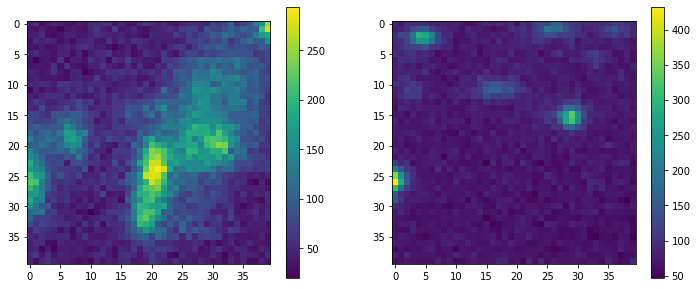

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(sim_frames[np.random.randint(0,len(sim_frames))])
plt.colorbar()
plt.subplot(122)
plt.imshow(data_frames[np.random.randint(0,len(data_frames)), 30:70,-40:])
plt.colorbar()

Once you are happy with you settings you can write the parameters to a file (or edit the param_friendly.yaml directly)

In [22]:
# import yaml
# with open('config/notebook_example.yaml', 'w') as file:
#     yaml.dump(param, file)

# to be replaced by
# decode.utils.param_io.ParamHandling().write_params('musterstrasse.yaml', param)

To start training execute:

In [ ]:
!python -m decode.neuralfitter.train.live_engine -p config/notebook_example.yaml